# Let's examine some data from Netflix

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import joblib

In [42]:
df= pd.read_csv('new_netflix2.csv')

In [43]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,14-Aug-20,2020.0,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,23-Dec-16,2016.0,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,20-Dec-18,2011.0,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,16-Nov-17,2009.0,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,1-Jan-20,2008.0,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [44]:
#how many missing values?
df.isna().sum()

show_id            0
type               0
title              0
director        2414
cast             717
country          511
date_added        10
release_year      30
rating             7
duration           0
listed_in          0
description        0
dtype: int64

Let's examine the duration of movies and tv shows separately:

In [45]:
#unique types of content:
df.type.unique()

array(['TV Show', 'Movie'], dtype=object)

In [46]:
tv_shows = df[df['type']=='TV Show']

Now, we'd expect most TV shows to be have their durations listed in seasons, but perhaps there are some that don't?

In [47]:
tv_shows[~tv_shows['duration'].str.contains('Season')]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
480,s481,TV Show,Amrapali,Lekh Tandon,"Vyjayantimala, Sunil Dutt, Prem Nath, Bipin Gu...",India,1-Jul-17,1966.0,TV-PG,116 min,"Dramas, International Movies, Music & Musicals",In the age of Buddha and his philosophy of non...
481,s482,TV Show,Amy,Asif Kapadia,"Amy Winehouse, Lauren Gilbert",United Kingdom,26-Jul-18,2015.0,R,128 min,"Documentaries, International Movies, Music & M...",Rare home videos and interviews with Amy Wineh...
482,s483,TV Show,Amy Schumer Growing,Amy Schumer,Amy Schumer,United States,19-Mar-19,2019.0,TV-MA,61 min,Stand-Up Comedy,"Amy Schumer spills on her new marriage, person..."
483,s484,TV Show,Amy Schumer: The Leather Special,Amy Schumer,Amy Schumer,United States,7-Mar-17,2017.0,TV-MA,57 min,Stand-Up Comedy,"Comic sensation Amy Schumer riffs on sex, dati..."
484,s485,TV Show,An American in Madras,Karan Bali,NaN,India,1-Jan-17,2013.0,TV-PG,80 min,"Documentaries, International Movies",Extensive film clips and interviews tell the s...
485,s486,TV Show,An American Tail,Don Bluth,"Erica Yohn, Nehemiah Persoff, Amy Green, Phill...",United States,"April 1, 2018",1986.0,G,80 min,Children & Family Movies,"Fievel, a young Russian mouse, immigrates to A..."
486,s487,TV Show,An American Tail: Fievel Goes West,"Phil Nibbelink, Simon Wells","Philip Glasser, James Stewart, Erica Yohn, Cat...",United States,"April 1, 2018",1991.0,G,75 min,Children & Family Movies,Fievel and his family head west for what turns...
487,s488,TV Show,An American Tail: The Mystery of the Night Mon...,Larry Latham,"Thomas Dekker, Lacey Chabert, Jane Singer, Neh...",United States,"April 1, 2018",1999.0,G,75 min,Children & Family Movies,When a monster goes on a mouse-napping spree i...
488,s489,TV Show,An American Tail: The Treasures of Manhattan I...,Larry Latham,"Thomas Dekker, Dom DeLuise, Pat Musick, Nehemi...",United States,"April 1, 2018",2000.0,G,79 min,Children & Family Movies,When Fievel and friends go hunting for buried ...
489,s490,TV Show,An Easy Girl,Rebecca Zlotowski,"Mina Farid, Zahia Dehar, Benoît Magimel, Nuno ...",France,13-Aug-20,2019.0,TV-MA,93 min,"Comedies, Dramas, International Movies",A teen girl is drawn to her cousin’s hedonisti...


Interesting! There are some TV shows that have a duration listed in minutes. Let's filter these out.

In [48]:
#now, extract numerical values
tv_shows = tv_shows[tv_shows['duration'].str.contains('Season')]
tv_shows['duration_num'] = tv_shows['duration'].apply(lambda x: int(x[0]))

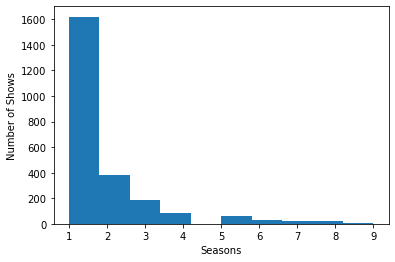

In [49]:
plt.hist(tv_shows.duration_num)
plt.xlabel('Seasons')
plt.ylabel('Number of Shows')
plt.show()

So here we see that most TV shows run for 1 or 2 seasons, and very few run for more than 4 seasons. Neat!

In [50]:
movies = df[df['type']=='Movie']

Similarly, is it possible for a movie to have a duration in seasons?

In [51]:
movies[movies['duration'].str.contains('Season')]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
7785,s7786,Movie,Zozo,NaN,Nasty C,India,31-Oct-20,2019.0,TV-PG,1 Season,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the nex...


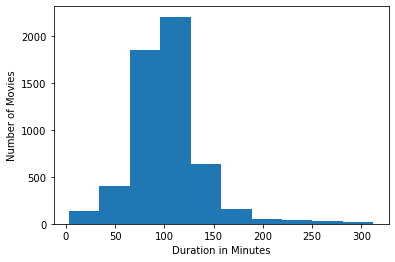

In [52]:
movies = movies[movies['duration'].str.contains('min')]
movies['duration_num'] = movies['duration'].apply(lambda x: int(x[:-4])) # this should  remove ' min' from durations
plt.hist(movies.duration_num)
plt.xlabel('Duration in Minutes')
plt.ylabel('Number of Movies')
plt.show()

After removing the movie with a 1 season duration, we see that most movies last around 100 minutes.

Let's take a look at the ratings now:

In [53]:
df['rating'].unique()

array(['TV-MA', 'R', 'PG-13', 'TV-14', 'TV-PG', 'NR', 'TV-G', 'TV-Y', nan,
       'TV-Y7', 'PG', 'G', 'NC-17', 'TV-Y7-FV', 'UR'], dtype=object)

<AxesSubplot:>

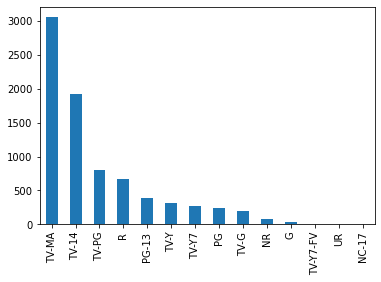

In [54]:
df['rating'].value_counts().plot(kind='bar')


Interesting! So we see that most content on Netflix has a TV-MA rating, followed by TV-14 and TV-PG.

##  Predict how long a movie will last (duration)

Before we proceed further, let's remove movies that have their duration in seasons, and TV shows with a duration in minutes.

In [55]:
#fill NAs
df['director'].fillna('unknown', inplace=True)
df['cast'].fillna('unknown', inplace=True)
df['country'].fillna('unknown', inplace = True)
df['date_added'].fillna('00-00-00', inplace = True)
df['release_year'].fillna(0, inplace = True)
df['rating'].fillna('unknown', inplace = True)
#remove movies that have their duration in seasons, and TV shows with a duration in minutes.
df = df[~((df['type']=='Movie') & (df['duration'].str.contains('Season')))]
df = df[~((df['type']=='TV Show') & (df['duration'].str.contains('min')))]

In [56]:
def getDuration(duration):
    wordList = duration.split(' ')
    length = int(wordList[0])
    return length

df['duration_num'] = df['duration'].apply(lambda x: getDuration(x))


In [57]:
def getYearAdded(dateAdded):
    if dateAdded == '00-00-00':
        return('0000')
    lastTwoDigYear = dateAdded[-2:]
    fourDigYear = int('20'+lastTwoDigYear)
    return(fourDigYear)

df['yearAdded'] = df['date_added'].apply(lambda x: getYearAdded(x))

In [58]:
df['release_year']=df['release_year'].astype('int')

Now let's get common topics in the `description` column using TFIDF

In [59]:
stop = stopwords.words('english') #remove stopwords
df['new_desc'] = df['description'].apply(lambda s: s.lower())
df['new_desc'] = df['new_desc'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
v = TfidfVectorizer(max_features=20)
x = v.fit_transform(df['new_desc'])

In [60]:
textData = pd.DataFrame(x.toarray(), columns = v.get_feature_names())
textData.head()

,band,behind,documentary,family,father,find,friends,life,look,love,man,must,new,one,school,series,two,woman,world,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
df = df.reset_index() #or else concat doesn't use the right indices
newdf = pd.concat([df,textData], axis=1)

In [62]:
#get cast count
newdf['cast_count'] = newdf['cast'].apply(lambda x: len(x.split(',')))
#get dummies for country and rating
newdf= pd.get_dummies(data=newdf, columns=['country', 'rating'])
#one-hot encode the genres
newdf['genres'] = newdf['listed_in'].apply(lambda x: x.split(','))
genredf = pd.get_dummies(newdf['genres'].explode()).sum(level=0)

In [63]:
newdf= pd.concat([newdf,genredf], axis=1)

Now, generate X and y matrices

In [64]:
moviedf = newdf[newdf['type']=='Movie']
X_movie, y_movie = moviedf.loc[:, ~moviedf.columns.isin(['type','index','show_id', 'title', 'cast', 'index', 'director','date_added', 'duration', 'listed_in', 'description', 'genres', 'new_desc',  'yearAdded'])], moviedf['duration_num']

In [65]:
X_movie

,release_year,duration_num,band,behind,documentary,family,father,find,friends,life,...,Sports Movies,Stand-Up Comedy,Stand-Up Comedy & Talk Shows,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Sci-Fi & Fantasy,TV Shows,Thrillers
1,2016,93,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,2011,78,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2009,80,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2008,123,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,2019,95,0.000000,0.000000,0.000000,0.0,0.0,0.714776,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7940,2002,298,0.523872,0.498784,0.450295,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7941,2003,299,0.523872,0.498784,0.450295,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7942,2004,300,0.523872,0.498784,0.450295,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7943,2005,301,0.523872,0.498784,0.450295,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
#assign the corresponding DMatrix
data_dmatrix_movie = xgb.DMatrix(data=X_movie,label=y_movie ,enable_categorical = True) 
#generate training and testing sets
X_train_movie, X_test_movie, y_train_movie, y_test_movie = train_test_split(X_movie,y_movie, test_size = .2)

In [67]:
#initialize model object
xg_reg_movie = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.2,
                max_depth = 8, alpha = 12, n_estimators = 10)

In [68]:
xg_reg_movie.fit(X_train_movie,y_train_movie)

XGBRegressor(alpha=12, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=12, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [69]:
preds = xg_reg_movie.predict(X_test_movie)

In [70]:
preds

array([100.41353 , 120.70808 ,  94.42343 , ..., 151.57852 ,  95.473015,
        76.9237  ], dtype=float32)

In [71]:
rmse = np.sqrt(mean_squared_error(y_test_movie, preds))
print("RMSE: %f" % (rmse))

RMSE: 11.711663


Wow! Our gradient boosting regression model has a root-mean-square error of about 12 minutes.
Can we do better?

In [72]:

# defining parameter range 
param_grid = {'learning_rate': [0.1, 0.15, 0.2, 0.25],  
              'gamma': [0,1,10], 
              'max_depth': [5,7,9],
             'alpha':[0,5,10]}  

grid = GridSearchCV(xgb.XGBRegressor(), param_grid, refit = True, verbose = 1,n_jobs=-1) 
grid.fit(X_train_movie, y_train_movie) 

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/home/andrew/anaconda3/envs/main/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/andrew/anaconda3/envs/main/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/andrew/anaconda3/envs/main/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/andrew/anaconda3/envs/main/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                          

In [73]:
print(grid.best_params_)

{'alpha': 0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9}


So here we see that optimal parameters include `learning_rate = 0.1, max_depth=9,` and `alpha=gamma=0`.

In [74]:
grid_predictions = grid.predict(X_test_movie)

In [75]:
grid_predictions

array([113.00589 , 134.97241 , 105.99662 , ..., 172.76758 , 106.9906  ,
        85.999725], dtype=float32)

In [76]:
new_rmse = np.sqrt(mean_squared_error(y_test_movie, grid_predictions))
print("RMSE: %f" % (new_rmse))

RMSE: 0.201678


After using gridsearch to identify a better set of hyperparameter configurations, we have a new model now that has an root-mean-squared error of 0.2 minutes, substantially better than the orignal error of 12 minutes!

In [77]:
joblib.dump(grid, 'netflix_xgboost.pkl')

['netflix_xgboost.pkl']

Now let's pickle this model and containerize it.